<a href="https://colab.research.google.com/github/sadavarterohit/EIBEC3-Diffusion/blob/main/FinDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required libaries.

In [1]:
# install required libraries
!pip install sdv # install the synthetic data vault library
"""
The sdv library is a synthetic data generation library.
Here, the authors have used it for ease of tests.
"""

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

'\nThe sdv library is a synthetic data generation library.\nHere, the authors have used it for ease of tests.\n'

Import required libraries.

In [6]:
# import data science libraries
import pandas as pd
import numpy as np
import math

"""
Math can be ignored becase it is only being used for log, we should use torch.log instead (minor detail)
"""

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

Init and set experiment parameters.

In [7]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

"""
cat_emb_dim * number of catergorical variables is the overall size of the categorical embeddings
"""
# set number of neurons per layer
mlp_layers = [1024, 1024, 1024, 1024]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

"""
y = root(beta) * xt-1 + root(1-beta) * noise

The beta is changing either 'linear'ly or 'quad'ratically depending on the scheduler.
"""
# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 500

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

Set random seed values.

In [8]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Load, pre-process, and init the UCU Credit Card dataset
The dataset is available under https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

In [9]:
# response.content

In [10]:
## set data path
#data_url = 'https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip'
#
## download the file
#response = requests.get(data_url)
#
## determine the zip file
#zip_file = ZipFile(BytesIO(response.content))
#
## extract the zip file
#zip_file.extractall('data')
#
## read the UCI credit card dataset
train_raw = pd.read_excel('default of credit card clients.xls', skiprows=[0])

Inspect the top 10 rows and attribute names of the dataset retreived.

In [11]:
# display top 10 rows
train_raw.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [12]:
# display attribute names
train_raw.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Set numerical and categorical dataset attributes.

In [13]:
'''
why is age cat?
PAYn: payment ontime in the last months: -1: ontime, 1: 1 month late, 2: 2 months late so on
PAYn not categorical?
idea: Treat is as numerical -> round to nearest integer for synthetic data; however, the distribution of PAYn may not work well with Quantile Transformer

Either way, ordinal encoding should work better than label encoder.

'''

# determine categorical attributes
cat_attrs = ['SEX', 'MARRIAGE','default payment next month']#, 'EDUCATION' , 'AGE', 'PAY0', 'PAY2', 'PAY3', 'PAY4', 'PAY5', 'PAY6']

int_attrs = ['EDUCATION', 'AGE', 'PAY0', 'PAY2', 'PAY3', 'PAY4', 'PAY5', 'PAY6']

# determine numerical attributes
num_attrs = ['LIMITBAL', 'BILLAMT1', 'BILLAMT2', 'BILLAMT3', 'BILLAMT4', 'BILLAMT5', 'BILLAMT6',
             'PAYAMT1', 'PAYAMT2', 'PAYAMT3', 'PAYAMT4', 'PAYAMT5', 'PAYAMT6']

num_attrs += int_attrs

Pre-process dataset attributes.

In [14]:
# extract label
label = train_raw['default payment next month']

In [15]:
# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', '') for col in train_raw.columns]

# convert categorical attributes to string
train_raw[cat_attrs] = train_raw[cat_attrs].astype(str)

# iterate over categorical attributes
for cat_attr in cat_attrs:

    # add col name to every categorical entry to make them distinguishable for embedding
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

Set dataset label.

Determine the training data.

In [16]:
# merge selected categorical and numerical attributes
train = train_raw[[*cat_attrs, *num_attrs]]

Transform the numerical attributes.

In [17]:
'''
Quantile Transformation chosen over Standard Scaler/ Power Method.
Fidelity score is the best when Quantile Transformation is chosen, according to the paper Section 6
'''

# init the quantile transformation
num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

# fit transformation to numerical attributes
num_scaler.fit(train[num_attrs])

# transform numerical attributes
train_num_scaled = num_scaler.transform(train[num_attrs])

Transform the categorical attributes.

In [18]:
'''
embedding chosen to avoid high demensionality of data (compared to one-hot encoding)
note: does not preserve ordinal nature of data (LabelEncoder assigns random numbers to each cat(vocab))
may not make sense for Age, Education, PAYN

as mentioned earlier, ordinal encoding should work better than label encoder, but since we are generating embeddings, can experiment with one hot as well.
'''

# get vocabulary of categorical attributes
vocabulary_classes = np.unique(train[cat_attrs])

# init categorical attribute encoder
label_encoder = LabelEncoder()

# fit encoder to categorical attributes
label_encoder.fit(vocabulary_classes)

# transform categorical attributes
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)

# collect unique values of each categorical attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

In [19]:
train_cat_scaled

,SEX,MARRIAGE,default payment next month
0,5,1,7
1,5,2,7
2,5,2,6
3,5,1,6
4,4,1,6
...,...,...,...
29995,4,1,6
29996,4,2,6
29997,4,2,7
29998,4,1,7


Convert numerical and categorical attributes as well as the labels to tensors.

In [20]:

# convert numerical attributes
train_num_torch = torch.FloatTensor(train_num_scaled)

# convert categorical attributes
train_cat_torch = torch.LongTensor(train_cat_scaled.values)

# convert label
label_torch = torch.LongTensor(label)

In [21]:
label

,default payment next month
0,1
1,1
2,0
3,0
4,0
...,...
29995,0
29996,0
29997,1
29998,1


Convert dataset to tensor dataset.

In [22]:
# init tensor dataset
train_set = TensorDataset(
    train_cat_torch, # categorical attributes
    train_num_torch, # numerical attributes
    label_torch # dataset labels
)

Init the data loader.

In [23]:
# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

## Implement the FinDiff model

Implement the FinDiff backbone model.

In [24]:
# define base feedforward network
class BaseNetwork(nn.Module):

    # define base network constructor
    def __init__(self, hidden_size, activation='lrelu'):

        # call super calass constructor
        super(BaseNetwork, self).__init__()
        """
        layers defined by default as [1024, 1024, 1024]
        """

        # init
        self.layers = self.init_layers(hidden_size)

        # case: lrelu activation
        if activation == 'lrelu':

            # set lrelu activation
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # case: relu activation
        elif activation == 'relu':

            # set relu activation
            self.activation = nn.ReLU(inplace=True)

        # case: tanh activation
        elif activation == 'tanh':

            # set tanh activation
            self.activation = nn.Tanh()

        # case: sigmoid activation
        else:

            # set sigmoid activation
            self.activation = nn.Sigmoid()

    # define layer initialization
    def init_layers(self, layer_dimensions):

        # init layers
        layers = []

        # iterate over layer dimensions
        for i in range(len(layer_dimensions)-1):

            # init linear layer
            layer = nn.Linear(layer_dimensions[i], layer_dimensions[i + 1], bias=True)

            # init linear layer weights
            nn.init.xavier_uniform_(layer.weight)
            """
            https://www.geeksforgeeks.org/xavier-initialization/
            smart way to initialise to get fastest convergence
            """

            # init linear layer bias
            nn.init.constant_(layer.bias, 0.0)

            # collecet linear layer
            layers.append(layer)

            # register linear layer parameters
            self.add_module('linear_' + str(i), layer)

        # return layers
        return layers

    # define forward pass
    def forward(self, x):

        # iterate over layers
        for i in range(len(self.layers)):

            # run layer forward pass
            x = self.activation(self.layers[i](x))

        # return forward pass result
        return x

Implement the FinDiff model synthesizer.

In [25]:
# define MLP synthesizer network
class MLPSynthesizer(nn.Module):

    # define MLP synthesizer network constructor
    def __init__(
            self,
            d_in: int,
            hidden_layers: list,
            activation: str='lrelu', # layer activation
            dim_t: int=64,
            n_cat_tokens=None, # number of categorical tokens
            n_cat_emb=None, # number of categorical dimensions
            embedding=None, #pretrained embedding
            embedding_learned=True,
            n_classes=None
        ):

        # call super class constructor
        super(MLPSynthesizer, self).__init__()

        # init ???
        self.dim_t = dim_t

        # init synthesizer base feed forward network
        self.backbone = BaseNetwork([dim_t, *hidden_layers], activation=activation)

        # case: categorical embedding defined
        if embedding is not None:

            # init pretrained embedding layer
            self.cat_embedding = nn.Embedding.from_pretrained(embeddings=embedding)

        # case: categorical embedding undefined
        else:

            # init new categorical embedding layer
            self.cat_embedding = nn.Embedding(n_cat_tokens, n_cat_emb, max_norm=None, scale_grad_by_freq=False)

            # activate categorical embedding layer learning
            self.cat_embedding.weight.requires_grad = embedding_learned

        # case: data classes available
        if n_classes is not None:

            # init label embedding layer
            self.label_embedding = nn.Embedding(n_classes, dim_t)

        # define input data projection
        self.projection = nn.Sequential(
            nn.Linear(d_in, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        """
        Projecting into higher space, but need to maintain same dimension for time and categorical so they can be summed.
        """

        # define time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define output data projection
        self.head = nn.Linear(hidden_layers[-1], d_in)

    # define sinusodial time step embedding
    def embed_time(self, timesteps, dim_out, max_period=10000):

        # half output dimension
        half_dim_out = dim_out // 2

        # determine tensor of frequencies
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)

        # push to compute device
        freqs = freqs.to(device=timesteps.device)

        # create timestep vs. frequency grid
        args = timesteps[:, None].float() * freqs[None]

        # creating the time embedding
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        """
        embedding is created from cosine and sine waves.
        This adds "timestep" information to the encoding process.
        """

        # case: odd output dimension
        if dim_out % 2:

            # append additional dimension
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)

        # return timestep embedding
        return time_embedding

    # get categorical embeddings
    def get_embeddings(self):

        # return categorical embeddings
        return self.cat_embedding.weight.data

    # perform categorical embedding
    def embed_categorical(self, x_cat):

        # perform categorical embedding
        x_cat_emb = self.cat_embedding(x_cat)

        # reshape embedding to original input
        x_cat_emb = x_cat_emb.view(-1, x_cat_emb.shape[1] * x_cat_emb.shape[2])

        # return categorical embedding
        return x_cat_emb

    # define forward pass
    def forward(self, x, timesteps, label=None):

        # init time embeddings
        time_emb = self.embed_time(timesteps, self.dim_t)

        # embedd time embeddings
        time_emb  = self.time_embed(time_emb )

        # case: data classes available
        if label is not None:

            # determine label embeddings
            time_label_emb = time_emb  + self.label_embedding(label)

        # run initial projection layer
        x = self.projection(x)

        # add time and label embedding
        x = x + time_label_emb

        # run backbone forward pass
        x =  self.backbone(x)

        # run projection forward pass
        x = self.head(x)

        # return forward pass result
        return x

Implement the FinDiff model base diffuser.

In [26]:
"""
This class diffuses noise into the data.
We can use different schedules etc.
"""

# define BaseDiffuser network
class BaseDiffuser(object):

    # define base diffuser network constructor
    def __init__(
            self,
            total_steps=1000,
            beta_start=1e-4,
            beta_end=0.02,
            device='cpu',
            scheduler='linear'
        ):

        # set diffusion steps
        self.total_steps = total_steps

        # set diffusion start beta
        self.beta_start = beta_start

        # set diffusion end beta
        self.beta_end = beta_end

        # set compute device
        self.device = device

        # set noise schedule alphas and betas
        self.alphas, self.betas = self.prepare_noise_schedule(scheduler=scheduler)

        # set noise schedule alhpa hats
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    # define noise schedule
    def prepare_noise_schedule(self, scheduler: str):

        # determine noise scheduler scale
        scale = 1000 / self.total_steps

        # scale beta start
        beta_start = scale * self.beta_start

        # scale beta end
        beta_end = scale * self.beta_end

        # case: linear noise scheduler
        if scheduler == 'linear':

            # determine linear noise schedule betas
            betas = torch.linspace(beta_start, beta_end, self.total_steps)

            # determine linear noise schedule alphas
            alphas = 1.0 - betas

        # case: quadratic noise scheduler
        elif scheduler == 'quad':

            # determine quadratic noise schedule betas
            betas = torch.linspace(self.beta_start ** 0.5, self.beta_end ** 0.5, self.total_steps) ** 2

            # determine quadratic noise schedule alphas
            alphas = 1.0 - betas

        # return noise scheduler alphas and betas
        return alphas.to(self.device), betas.to(self.device)

    # define random timesteps sampler
    def sample_random_timesteps(self, n: int):

        # sample random timesteps
        t = torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

        # return random timesteps
        return t

    # define gaussian noise addition
    def add_gauss_noise(self, x_num, t):

        # determine noise alpha hat
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None]

        # determine numeric noise
        noise_num = torch.randn_like(x_num)

        # determine x numeric noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        # return x numeric noise and numeric noise
        return x_noise_num, noise_num

    # define gaussian noise sampling
    def p_sample_gauss(self, model_out, z_norm, timesteps):

        # determine noise alpha hat
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None]

        # determine noise betas
        betas_t = self.betas[timesteps][:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None]

        epsilon_t = torch.sqrt(self.betas[timesteps][:, None])

        # determine random noise
        random_noise = torch.randn_like(z_norm)
        random_noise[timesteps == 0] = 0.0

        # determine model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # determine z norm
        z_norm = model_mean + (epsilon_t * random_noise)

        # return z norm
        return z_norm

## Initialize and train the FinDiff model

In [27]:
# determine number unique categorical tokens
n_cat_tokens = len(np.unique(train[cat_attrs]))

# determine total categorical embedding dimension
cat_dim = cat_emb_dim * len(cat_attrs)

# determine total numerical embedding dimension
num_dim = len(num_attrs)

# determine total embedding dimension
encoded_dim = cat_dim + num_dim

In [28]:
# initialize the FinDiff synthesizer model
synthesizer_model = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=mlp_layers,
    activation=activation,
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=cat_emb_dim,
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

In [29]:
# initialize the FinDiff base diffuser model
diffuser_model = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler,
    device=device
)

Init optimizer, scheduler and loss function.

In [30]:
# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [31]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
synthesizer_model.train()

# move to the device
synthesizer_model = synthesizer_model.to(device)

# init the training progress bar
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # init epoch training batch losses
    batch_losses = []

    # iterate over epoch batches
    for batch_cat, batch_num, batch_y in dataloader:

        # move tensors to device
        batch_cat = batch_cat.to(device)
        batch_num = batch_num.to(device)
        batch_y = batch_y.to(device)

        # sample diffusion timestep
        timesteps = diffuser_model.sample_random_timesteps(n=batch_cat.shape[0])

        # determine categorical embeddings
        batch_cat_emb = synthesizer_model.embed_categorical(x_cat=batch_cat)

        # concatenate categorical and numerical embeddings
        batch_cat_num = torch.cat((batch_cat_emb, batch_num), dim=1)

        # add diffuser gaussian noise
        batch_noise_t, noise_t = diffuser_model.add_gauss_noise(x_num=batch_cat_num, t=timesteps)

        # conduct synthesizer model forward pass
        predicted_noise = synthesizer_model(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        """
        actual noise against predicted noise from the model.
        """

        # compute training batch loss
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)

        # reset model gradients
        optimizer.zero_grad()

        # run model backward pass
        batch_loss.backward()

        # optimize model parameters
        optimizer.step()

        # collect training batch losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # determine mean training epoch loss
    batch_losses_mean = np.mean(np.array(batch_losses))

    # update learning rate scheduler
    lr_scheduler.step()

    # collect mean training epoch loss
    train_epoch_losses.append(batch_losses_mean)

    # prepare and set training epoch progress bar update
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('[LOG {}] epoch: {}, train-loss: {}'.format(str(now), str(epoch).zfill(4), str(batch_losses_mean)))


[LOG 2025-05-24 01:20:52] epoch: 0499, train-loss: 0.15316051: 100%|██████████| 500/500 [05:07<00:00,  1.63it/s]


Visualize training loss progression.

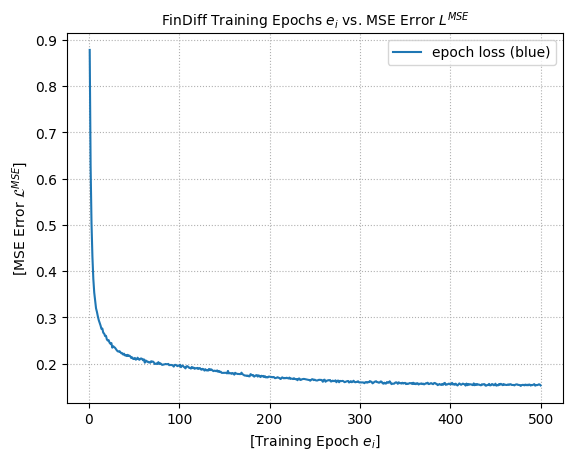

In [32]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[Training Epoch $e_i$]', fontsize=10)
ax.set_ylabel('[MSE Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc='upper right', numpoints=1, fancybox=True)

# add plot title
plt.title('FinDiff Training Epochs $e_i$ vs. MSE Error $L^{MSE}$', fontsize=10);

## Generate Data using the FinDiff model

Init and set sampling parameters.

Use FinDiff to generate new data samples.

In [66]:
# init samples to be generated
samples = torch.randn((len(label_torch), encoded_dim), device=device)

# init the generation progress bar
pbar = tqdm(iterable=reversed(range(0, diffusion_steps)), position=0, leave=True)

with torch.no_grad():
  # iterate over diffusion steps
  for diffusion_step in pbar:

      # prepare and set training epoch progress bar update
      now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
      pbar.set_description('[LOG {}] Diffusion Step: {}'.format(str(now), str(diffusion_step).zfill(4)))

      # init diffusion timesteps
      timesteps = torch.full((len(label_torch),), diffusion_step, dtype=torch.long, device=device)

      # run synthesizer model forward pass
      model_out = synthesizer_model(x=samples.float(), timesteps=timesteps, label=label_torch.to(device))

      # run diffuser model forward pass
      samples = diffuser_model.p_sample_gauss(model_out, samples, timesteps)


[LOG 2025-05-24 02:26:38] Diffusion Step: 0000: : 500it [00:30, 16.24it/s]


Decode generated FinDiff samples.

In [67]:
# split sample into numeric and categorical parts
samples = samples.detach().cpu().numpy()
samples_num = samples[:, cat_dim:]
samples_cat = samples[:, :cat_dim]

# denormalize numeric attributes
z_norm_upscaled = num_scaler.inverse_transform(samples_num)
z_norm_df = pd.DataFrame(z_norm_upscaled, columns=num_attrs)

# get embedding lookup matrix
embedding_lookup = synthesizer_model.get_embeddings().cpu()

# reshape back to batch_size * n_dim_cat * cat_emb_dim
samples_cat = samples_cat.reshape(-1, len(cat_attrs), cat_emb_dim)

# compute pairwise distances
distances = torch.cdist(x1=embedding_lookup, x2=torch.Tensor(samples_cat))

# get the closest distance based on the embeddings that belong to a column category
z_cat_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

nearest_dist_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

# iterate over categorical attributes
for attr_idx, attr_name in enumerate(cat_attrs):

    attr_emb_idx = list(vocab_per_attr[attr_name])
    attr_distances = distances[:, attr_emb_idx, attr_idx]

    nearest_values, nearest_idx = torch.min(attr_distances, dim=1)
    nearest_idx = nearest_idx.cpu().numpy()

    z_cat_df[attr_name] = np.array(attr_emb_idx)[nearest_idx]  # need to map emb indices back to column indices
    nearest_dist_df[attr_name] = nearest_values.cpu().numpy()

z_cat_df = z_cat_df.apply(label_encoder.inverse_transform)

'''
Round off int and clip range
'''
for x in int_attrs:
    if x in z_norm_df.columns:
        z_norm_df[x] = z_norm_df[x].round()
        if 'PAY' in x:
            z_norm_df[x] = z_norm_df[x].clip(lower=-1)
        if x == 'EDUCATION':
            z_norm_df[x] = z_norm_df[x].clip(lower=1, upper=4)

samples_decoded = pd.concat([z_cat_df, z_norm_df], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



In [68]:
samples_decoded.head(10)

,SEX,MARRIAGE,default payment next month,LIMITBAL,BILLAMT1,BILLAMT2,BILLAMT3,BILLAMT4,BILLAMT5,BILLAMT6,...,PAYAMT5,PAYAMT6,EDUCATION,AGE,PAY0,PAY2,PAY3,PAY4,PAY5,PAY6
0,SEX_2,MARRIAGE_0,default payment next month_1,330000.000000,390.000000,176.533661,0.000000,0.000000,0.000000,372.830719,...,0.000000,0.000000,2.0,27.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEX_2,MARRIAGE_2,default payment next month_1,250006.140625,0.000000,0.000000,163.468185,13162.976562,5152.506348,1789.663452,...,2193.411133,1501.882324,2.0,33.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
2,SEX_2,MARRIAGE_3,default payment next month_0,200000.000000,27491.335938,38410.605469,42159.414062,29253.916016,18909.511719,16341.192383,...,3328.684326,3200.849609,2.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SEX_1,MARRIAGE_3,default payment next month_0,80000.000000,6729.862305,4826.978516,4653.344727,16875.748047,25709.263672,24493.177734,...,4000.000000,1000.000000,1.0,40.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0
4,SEX_2,MARRIAGE_2,default payment next month_0,280000.000000,163195.453125,202813.062500,172238.500000,188472.796875,183207.406250,207013.437500,...,9023.090820,7527.102051,3.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0
5,SEX_2,MARRIAGE_2,default payment next month_0,220000.000000,499.752350,-81.341629,-13.254248,-42.722183,0.000000,0.000000,...,0.000000,3000.000000,1.0,32.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0
6,SEX_2,MARRIAGE_3,default payment next month_0,50000.000000,62200.265625,66827.726562,67216.046875,79727.750000,49073.664062,47683.476562,...,2800.000000,2500.000000,2.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
7,SEX_2,MARRIAGE_1,default payment next month_0,178484.828125,2477.809082,3977.776367,1515.305420,6079.914062,9709.625977,0.000000,...,0.000000,0.000000,2.0,49.0,0.0,0.0,-1.0,-1.0,0.0,0.0
8,SEX_1,MARRIAGE_2,default payment next month_0,120000.000000,49189.300781,24156.414062,42983.824219,55229.972656,31040.392578,47914.968750,...,1478.379028,0.000000,2.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0
9,SEX_2,MARRIAGE_3,default payment next month_0,200000.000000,30287.023438,2498.401367,2593.354736,25404.693359,42769.527344,13089.391602,...,6417.182617,5000.000000,2.0,47.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [69]:
samples_decoded.to_csv('Credit_default_findiff_original.csv')

import pickle

# Save the object to a pickle file
filename = 'credit_default_findiff.pkl'
with open(filename, 'wb') as file:
    pickle.dump(synthesizer_model, file)

print(f"Object saved to {filename}")

Object saved to credit_default_findiff.pkl


## Evaluate the Generated Data

In [70]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 56.73it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 116.41it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



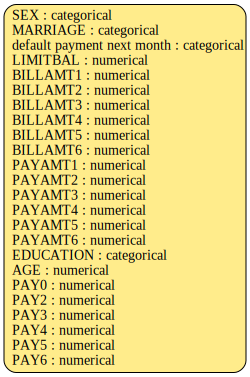

In [71]:
metadata.visualize()

In [72]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,SEX,TVComplement,0.996600
1,MARRIAGE,TVComplement,0.688433
2,default payment next month,TVComplement,1.000000
3,LIMITBAL,KSComplement,0.943500
4,BILLAMT1,KSComplement,0.980467
5,BILLAMT2,KSComplement,0.981933
6,BILLAMT3,KSComplement,0.980200
7,BILLAMT4,KSComplement,0.981267
8,BILLAMT5,KSComplement,0.977300
9,BILLAMT6,KSComplement,0.977800


In [73]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()

In [74]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig.show()

In [75]:
import sdv

for col in num_attrs:
  quality_report = sdv.evaluation.single_table.evaluate_quality(train, samples_decoded, metadata)
  fig = sdv.evaluation.single_table.get_column_plot(
      real_data=train,
      synthetic_data=samples_decoded,
      metadata=metadata,
      column_name=col
  )

  fig.show()

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 57.10it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 113.41it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 51.89it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 103.12it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 50.31it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 115.24it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 53.09it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 114.21it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 54.32it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 114.48it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 37.35it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 103.44it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 53.24it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 113.04it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 53.79it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 114.29it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 42.10it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:03<00:00, 87.83it/s]| 
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 54.16it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 114.51it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 52.52it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 114.89it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 54.11it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:03<00:00, 87.94it/s]| 
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 52.47it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 112.67it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 49.59it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 113.34it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 50.16it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 99.46it/s]| 
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 50.98it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 110.79it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 52.71it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 110.80it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 50.08it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 101.83it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 39.89it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 109.86it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 50.49it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 111.36it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 51.52it/s]|
Column Shapes Score: 93.32%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:02<00:00, 111.21it/s]|
Column Pair Trends Score: 88.27%

Overall Score (Average): 90.79%



In [76]:
from sdmetrics.single_column import BoundaryAdherence
from sdmetrics.single_column import RangeCoverage

for i in num_attrs:
    print(i +  " " +
    str(BoundaryAdherence.compute(
        real_data=train[i],
        synthetic_data=samples_decoded[i]
    ))
       + ", RangeCoverage  " +
          str(RangeCoverage.compute(
              real_data=train[i],
        synthetic_data=samples_decoded[i]
          )) )

LIMITBAL 1.0, RangeCoverage  0.9913761363636364
BILLAMT1 1.0, RangeCoverage  0.9786883589463149
BILLAMT2 1.0, RangeCoverage  0.9082922466571621
BILLAMT3 1.0, RangeCoverage  0.38407915580134666
BILLAMT4 1.0, RangeCoverage  0.8577033119549429
BILLAMT5 1.0, RangeCoverage  0.9756001302670785
BILLAMT6 1.0, RangeCoverage  0.8940849091692943
PAYAMT1 1.0, RangeCoverage  0.5780995292781654
PAYAMT2 1.0, RangeCoverage  0.7276398701149882
PAYAMT3 1.0, RangeCoverage  1.0
PAYAMT4 1.0, RangeCoverage  0.8516859903381643
PAYAMT5 1.0, RangeCoverage  0.9799802592555255
PAYAMT6 1.0, RangeCoverage  0.704268916953237
EDUCATION 1.0, RangeCoverage  0.5
AGE 1.0, RangeCoverage  0.896551724137931
PAY0 1.0, RangeCoverage  0.9
PAY2 1.0, RangeCoverage  0.8
PAY3 1.0, RangeCoverage  0.9
PAY4 1.0, RangeCoverage  0.8
PAY5 1.0, RangeCoverage  0.8
PAY6 1.0, RangeCoverage  0.8


In [77]:
from sdmetrics.single_column import CategoryAdherence
from sdmetrics.single_column import CategoryCoverage

for i in cat_attrs:
    print(i +  " CategoryAdherence" +
    str(CategoryAdherence.compute(
        real_data=train[i],
        synthetic_data=samples_decoded[i]
    ))
    + ", CategoryCoverage : " + str(CategoryCoverage.compute(
        real_data=train[i],
        synthetic_data=samples_decoded[i]
    )))


SEX CategoryAdherence1.0, CategoryCoverage : 1.0
MARRIAGE CategoryAdherence1.0, CategoryCoverage : 1.0
default payment next month CategoryAdherence1.0, CategoryCoverage : 1.0


In [88]:
from sklearn.model_selection import train_test_split

train_, test = train_test_split(train, test_size=0.3, random_state=42)

In [90]:
'''
Compute Utility Score
'''

from sdmetrics.single_table import  BinaryDecisionTreeClassifier

synthetic_data_f1 = BinaryDecisionTreeClassifier.compute(
    test_data=test,
    train_data=samples_decoded,
    target='default payment next month',
    metadata=metadata.to_dict()
)

real_data_f1 = BinaryDecisionTreeClassifier.compute(
    test_data=test,
    train_data=train_,
    target='default payment next month',
    metadata=metadata.to_dict()
)

print(f'Utility Score: {min(synthetic_data_f1/real_data_f1 , 1)}')

Utility Score: 0.9666987361390121


In [102]:
from sdmetrics.single_table import DCRBaselineProtection

privacy = DCRBaselineProtection.compute_breakdown(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata.to_dict(),
    num_rows_subsample = 100,
    num_iterations =50
)
print(f'Privacy Score: {privacy["score"]}')

Privacy Score: 0.11598481692175538


In [106]:
privacy

{'score': 0.11598481692175538,
 'median_DCR_to_real_data': {'synthetic_data': 0.07084390783016485,
  'random_data_baseline': 0.6108166054095758}}

In [105]:
from sdmetrics.single_table import NewRowSynthesis

NewRowSynthesis.compute(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata.to_dict(),
    numerical_match_tolerance=0.01,
    synthetic_sample_size=3000
)

1.0